# Geometry Transformations

Tidy3D has a rich set of classes and functions for the creation complex geometries. The set of primitive solids supported is:

- [Box](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Box.html): rectangular prism.

- [Sphere](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Sphere.html): regular sphere.

- [Cylinder](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Cylinder.html): cylinder with optinal angled sidewalls along the main axis.

- [PolySlab](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PolySlab.html): polygon extruded along its normal axis with optional angled sidewalls.

- [TriangleMesh](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.TriangleMesh.html): general polyhedra defined by triangular faces in 3D.

To create more complex geometries, these primitives can be transformed and combined using the derived classes:

- [Transformed](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Transformed.html): representation of a transformation applied to a base geometry.

- [GeometryGroup](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.GeometryGroup.html): union of a set of geometric objects.

- [ClipOperation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ClipOperation.html): set operation between other geometric objects (equivalent to boolean operations).

This notebook shows a few examples of geometry transformations that can be useful when creating complex simulations.

In [1]:
import tidy3d as td
import numpy as np
from matplotlib import pyplot as plt

## Simple Transformations

All geometries can be translated, rotated and scaled.
These methods create a new copy of the original geometry with the transformation applied.
For example, we can start with a `Box` centered at the origin and create a copy of it rotated around the z axis:

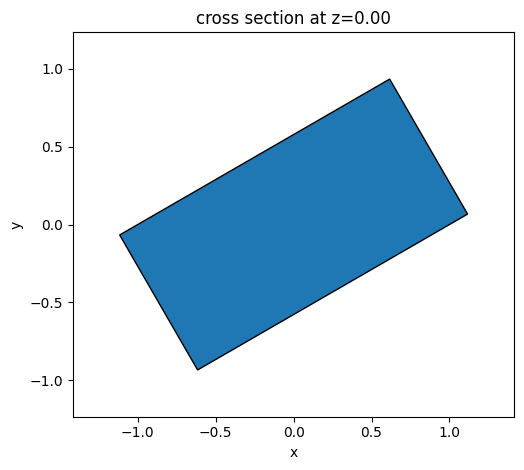

In [2]:
box = td.Box(size=(2, 1, 1))

rotated_box = box.rotated(np.pi / 6, axis=2)

_ = rotated_box.plot(z = 0)

Transformed geometries can be further transformed.
Composing transformations is as simple as cascading the method calls.
In this example, we create an ellipsoidal prism by scaling a primitive cylinder and then rotating it.

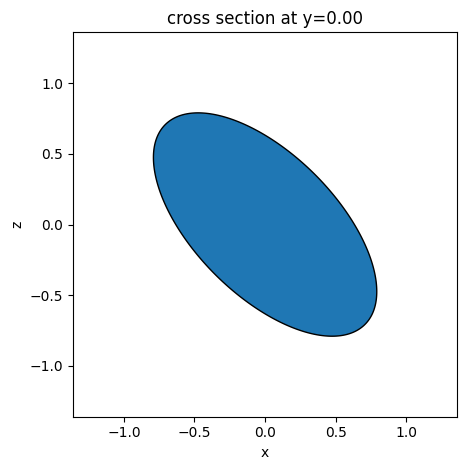

In [3]:
ellipsoid = td.Cylinder(radius=0.5, length=0.5, axis=1).scaled(x=2, y=1, z=1).rotated(np.pi / 4, axis=1)

_ = ellipsoid.plot(y=0)

By composing rotations and translations, we can create a cylindrical array of boxes.
In this example, we're also using the `GeometryGroup` class to group the indididual geometries into a single object.
That group can also be used as any other geometrical object and freely transformed.

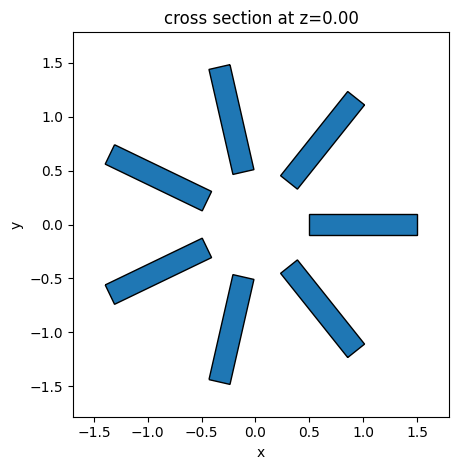

In [4]:
mark = td.Box(center=(1, 0, 0), size=(1, 0.2, 0.1))

cylindrical_array = []

for angle in np.linspace(0, 2 * np.pi, 7, endpoint=False):
    cylindrical_array.append(mark.rotated(angle, axis=2))

marks = td.GeometryGroup(geometries=cylindrical_array)

_ = marks.plot(z=0)

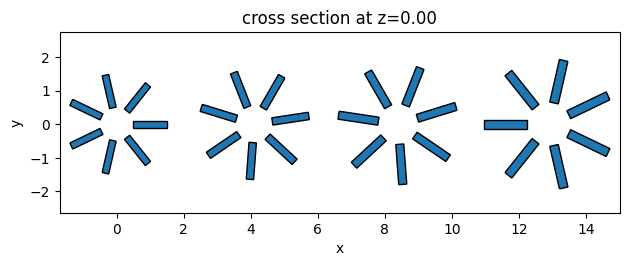

In [5]:
transformed_marks = []

for i in range(4):
    s = 1 + i / 10
    transformed_marks.append(
        marks.scaled(s, s, s).rotated(i * np.pi / 3, axis=2).translated(i * (4 + i / 10), 0, 0)
    )

stars = td.GeometryGroup(geometries=transformed_marks)

_ = stars.plot(z=0)

## General Transformations

The type of the objects created by geometry transformations is `Transformed`.
We can check that easily:

In [6]:
type(rotated_box)

tidy3d.components.geometry.base.Transformed

A `Transformed` object contains an inner geometry and a transformation, written as a [4×4 matrix](https://en.wikipedia.org/wiki/Transformation_matrix) and applied to the (homogeneous) coordinates of the inner geometry.
It is possible to define a `Transformed` object directly from the inner geometry and the transformation.
To help create the most ususal transformation matrices, the `Transformed` class has 3 static methods for `translation`, `rotation`, and `scaling` that can be used and combined (the `@` operator can be used for matrix multiplication with numpy arrays).

In [7]:
rot = td.Transformed.rotation(np.pi / 3, axis=(1, 1, 1))
trans = td.Transformed.translation(1, 2, 0)
scale = td.Transformed.scaling(1, 1.25, 1)

print("Rotation matrix:\n\n", rot)

print("\nTranslation and rotation matrices combined:\n\n", trans @ rot)

Rotation matrix:

 [[ 0.66666667 -0.33333333  0.66666667  0.        ]
 [ 0.66666667  0.66666667 -0.33333333  0.        ]
 [-0.33333333  0.66666667  0.66666667  0.        ]
 [ 0.          0.          0.          1.        ]]

Translation and rotation matrices combined:

 [[ 0.66666667 -0.33333333  0.66666667  1.        ]
 [ 0.66666667  0.66666667 -0.33333333  2.        ]
 [-0.33333333  0.66666667  0.66666667  0.        ]
 [ 0.          0.          0.          1.        ]]


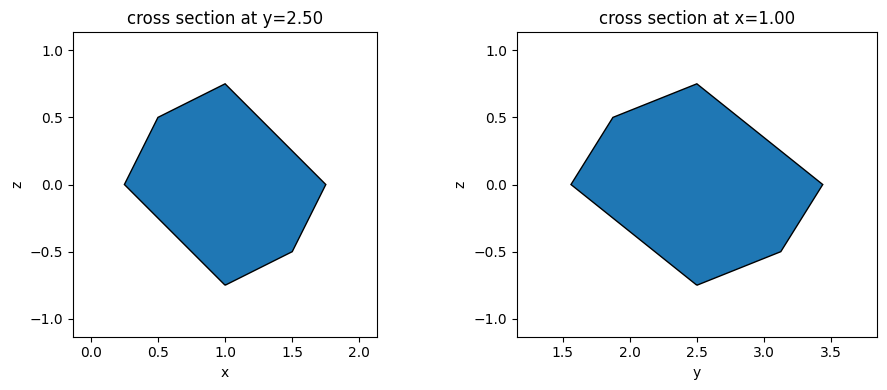

In [8]:
# The box is first rotated, then translated, and finally scaled
transformed = td.Transformed(geometry=td.Box(size=(1, 1, 1)), transform=scale @ trans @ rot)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
_ = transformed.plot(y=2.5, ax=ax[0])
_ = transformed.plot(x=1, ax=ax[1])

Of course, transformations can be defined in any way.
The only requirement is that the transformation matrix is not singular.

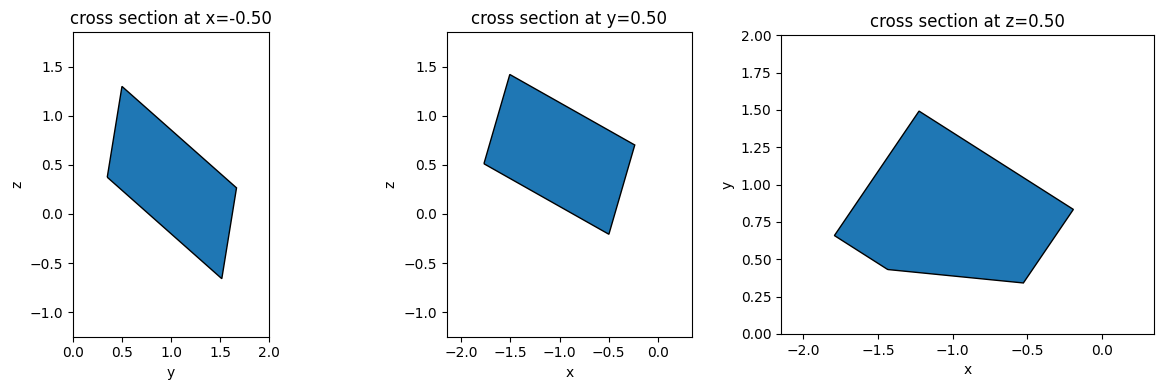

In [9]:
transformed = td.Transformed(
    geometry=td.Box(size=(1, 1, 1)),
    transform=[
        [1.2, 0.4, 0.3, -0.9],
        [-0.2, 1.1, 0.1, 1.0],
        [-0.5, -1.2, 0.8, 0.3],
        [0.1, -0.2, -0.6, 1.1],
    ],
)

fig, ax = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

_ = transformed.plot(x=-0.5, ax=ax[0])
_ = transformed.plot(y=0.5, ax=ax[1])
_ = transformed.plot(z=0.5, ax=ax[2])

## Clip Operations

Geometries can be combined through clip operations, which are analogous to set or boolean operations.
Union (or), intersection (and), difference (and not), and symmetric difference (xor) are available to use with Tidy3D geometry objects.
These operations can be simply written using the expected mathematical operations for each:

- Union: `a + b`
- Intersection: `a * b`
- Difference: `a - b`
- Symmetric difference: `a ^ b`

As an example, a half-sphere can be created by intersecting a sphere and a box primitives:

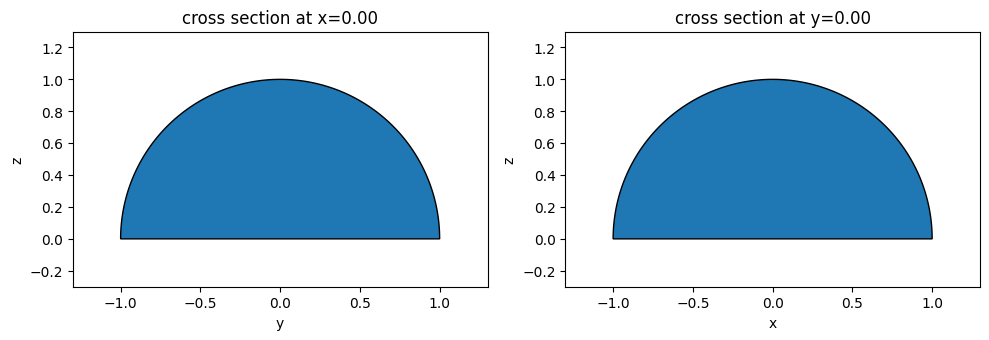

In [10]:
sph = td.Sphere(radius=1)
box = td.Box(center=(0, 0, 1), size=(2, 2, 2))
half_sph = sph * box

fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

_ = half_sph.plot(x=0, ax=ax[0])
_ = half_sph.plot(y=0, ax=ax[1])

A ring shape can be created by subtracting 2 cylinders of appropriate diameters:

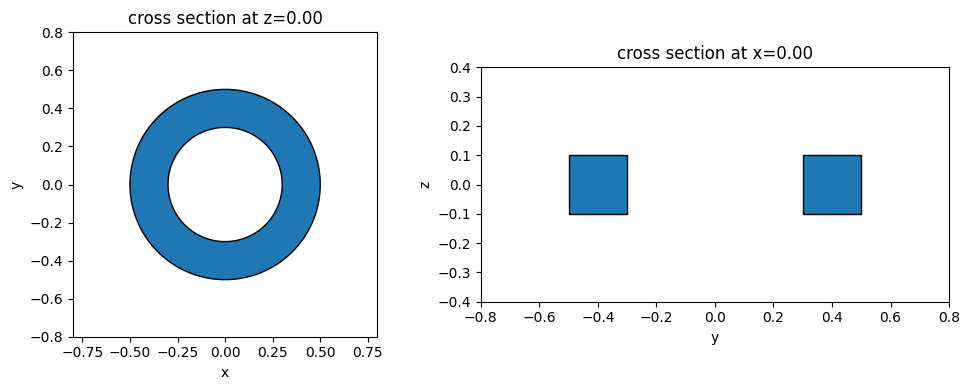

In [11]:
cyl = td.Cylinder(radius=0.5, length=0.2)
inner_cyl = td.Cylinder(radius=0.3, length=0.2)

ring = cyl - inner_cyl

fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

_ = ring.plot(z=0, ax=ax[0])
_ = ring.plot(x=0, ax=ax[1])

The `ClipOperation` class cen be used directly to perform the same operations, if desired:

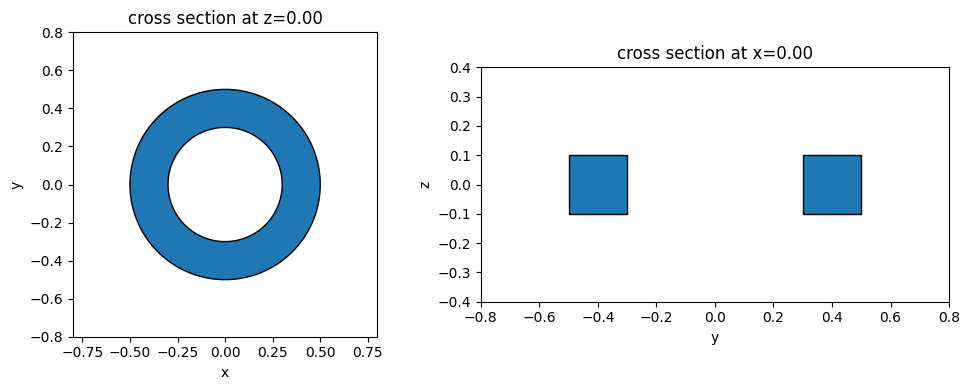

In [12]:
ring2 = td.ClipOperation(operation="difference", geometry_a=cyl, geometry_b=inner_cyl)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

_ = ring2.plot(z=0, ax=ax[0])
_ = ring2.plot(x=0, ax=ax[1])

## Other examples

### Elliptical ring

By starting from a base cylinder with unit radius, we can create an elliptical ring by scaling and subtracting:

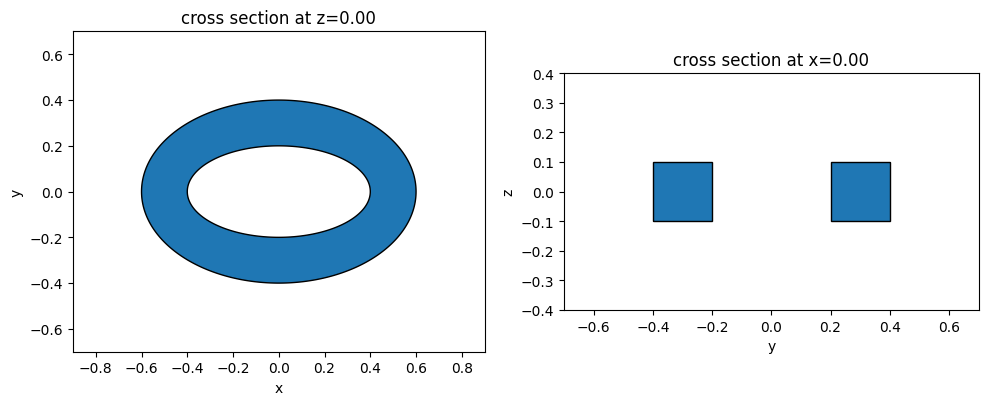

In [13]:
base_cyl = td.Cylinder(radius=1, length=0.2)
ell_ring = base_cyl.scaled(0.6, 0.4, 1) - base_cyl.scaled(0.4, 0.2, 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

_ = ell_ring.plot(z=0, ax=ax[0])
_ = ell_ring.plot(x=0, ax=ax[1])

### Angled waveguide

When we want to create a waveguide with angled sidewalls, we don't allways want the end facets to be angled as well.
We can use an extra box to trim down the facet angle:

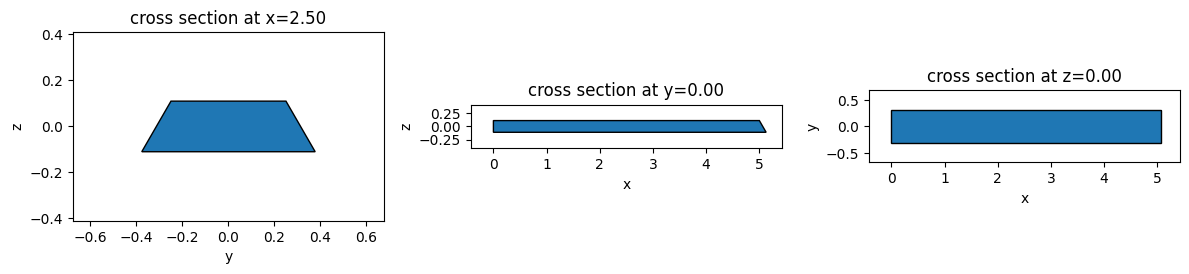

In [14]:
angled_sidewalls = td.PolySlab(
    vertices=[(0, -0.25), (5, -0.25), (5, 0.25), (0, 0.25)],
    reference_plane="top",
    sidewall_angle=np.pi / 6,
    slab_bounds=(-0.11, 0.11),
)

waveguide = angled_sidewalls - td.Box(center=(-0.5, 0, 0), size=(1, 1, 0.25))

fig, ax = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

_ = waveguide.plot(x=2.5, ax=ax[0])
_ = waveguide.plot(y=0, ax=ax[1])
_ = waveguide.plot(z=0, ax=ax[2])

### Pattern intersection

Overlapping patterns can be usefull, for example, when combining diffraction gratings or creating complex phase plates.
The symmetric difference operation (XOR) can be useful in such cases:

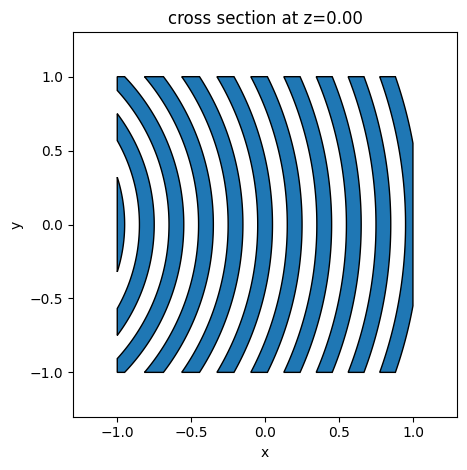

In [15]:
def ring(radius):
    outer = td.Cylinder(center=(-2, 0, 0), radius=radius + 0.05, length=0.1, axis=2)
    inner = td.Cylinder(center=(-2, 0, 0), radius=radius - 0.05, length=0.1, axis=2)
    return outer - inner

pattern1 = td.GeometryGroup(geometries=[ring(0.2 * i) for i in range(5, 16)]) * td.Box(size=(2, 2, 0.1))

_ = pattern1.plot(z=0)

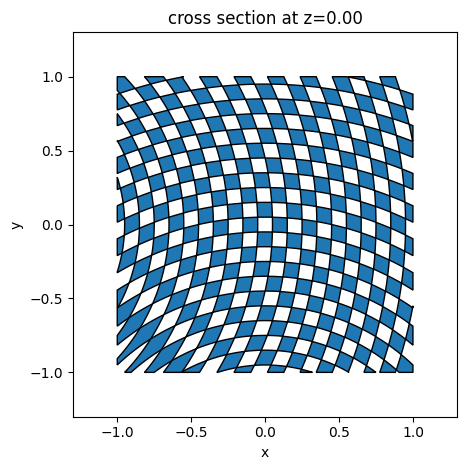

In [16]:
pattern2 = pattern1.rotated(np.pi / 2, axis=2)

pattern_overlap = pattern1 ^ pattern2

_ = pattern_overlap.plot(z=0)

### Woodpile Photonic Crystal


In this example we build the 3D photonic crystal cavity proposed by Léon A. Woldering, Allard P. Mosk, and Willem L. Vos, _Phys. Rev. B_ **90**, 115140 (2014), [doi: 10.1103/PhysRevB.90.115140](https://doi.org/10.1103/PhysRevB.90.115140)

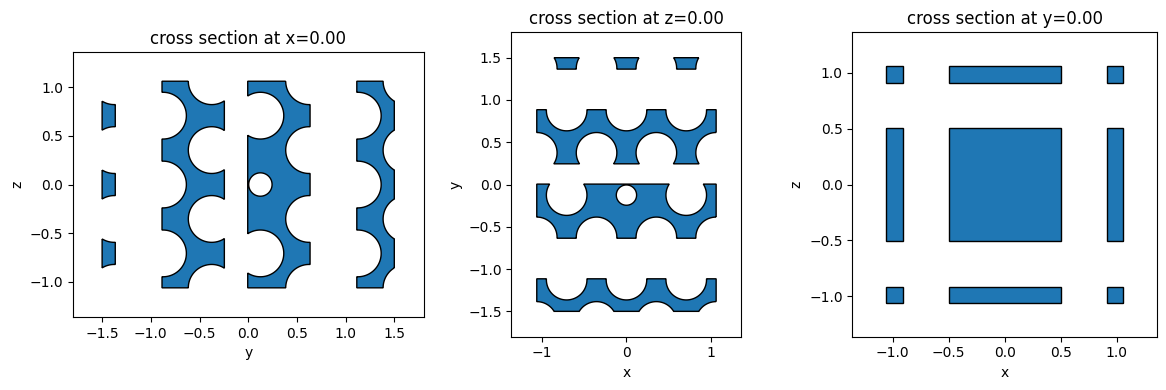

In [17]:
a = 1.0            # Out-of-plane lattice period
c = a * 2 ** -0.5  # In-plane lattice period
r = a * 0.24       # Pore radius
r_pert = r * 0.5   # Perturbed pore radius
n = 3              # Number of periods (odd for a centered cavity)

pores = []

length = (n + 1) * c
for k in range(n + 1):
    y = (k - n * 0.5 - 0.125) * a
    for i in range(n + 1):
        p = (i - n * 0.5) * c
        r_ik = r_pert if k == n // 2 and i == n // 2 else r
        
        # z-aligned pores
        pore = td.Cylinder(center=(p, y, 0), length=length, radius=r, axis=2)
        pores.append(pore)
        if i < n and k < n:
            pore = td.Cylinder(
                center=(p + 0.5 * c, y + 0.5 * a, 0), length=length, radius=r_ik, axis=2
            )
            pores.append(pore)
        
        # x-aligned pores
        pore = td.Cylinder(center=(0, y + 0.25 * a, p), length=length, radius=r, axis=0)
        pores.append(pore)
        if i < n and k < n:
            pore = td.Cylinder(
                center=(0, y + 0.75 * a, p + 0.5 * c), length=length, radius=r_ik, axis=0
            )
            pores.append(pore)


pore_geo = td.Box(size=(n * c, n * a, n * c)) - td.GeometryGroup(geometries=pores)

fig, ax = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

_ = pore_geo.plot(x=0, ax=ax[0])
_ = pore_geo.plot(z=0, ax=ax[1])
_ = pore_geo.plot(y=0 * a, ax=ax[2])